In [1]:
%matplotlib inline

A Survey of the XY Model using Variational Quantum Thermalizer
=====================================================

This demonstration discusses simulates the XY model using technqiues of the Variational Quantum Thermalizer(https://arxiv.org/abs/1910.02071). In this demonstration we obtain the thermal density matrix for various temperatures by minimizing the cost function of our quantum circuit, and explore the properties of the XY model in the 1 dimensional 4 qubit model, and the two dimensional 9 dubit model. We see that the density matrix obtained by VQT demonstrates the properties of the XY model by plotting the specific heat and magnetization, and finding the critical temperatures by comparing the trace distances between various thermal density matrices. 

The Variational Quantum Thermalizer
===============================

The Variational Quantum Thermalizer is a modified VQE algorithm which aims to obtain the mixed thermal state of the Hamiltonian at a certain temperature T. Letting $\beta = \frac{1}{T}$, we can define the thermal density matrix as follows:
$$\rho_\text{thermal} \ = \ \frac{e^{- \hat{H} \beta}}{\text{Tr}(e^{- \hat{H} \beta})} \ = \ \frac{e^{- \hat{H} \beta}}{Z_{\beta}},$$

Since the density matrix is mixed, we must average the $<H>$ for some ansatz over a probability distribution,$p_i(\theta)$  Letting the unitary of our ansatz we $U(\phi)$, where $\phi$ is an adjustable parameter. For our cost function, since the volume of our system is constant, we slightly modify the Helmholtz free energy:
$$F = U-TS$$
$$\beta F = \beta U - S$$

Letting $\mathcal{L}(\phi, \theta) = \beta F$ and, $U = <H>$, we obtain the following for our cost function:

$$\mathcal{L}(\phi, \theta) = \beta\ Tr[U(\phi)\rho_{\theta} U^{\dagger}] - S$$

Here, we define S in terms of $\rho$ according to the von Neumann entropy:
$$ S = -Tr[\rho_{\theta} \log \rho_{\theta}] $$



XY Heisenberg Model
==================
References: https://en.wikipedia.org/wiki/Classical_XY_model

The XY model is a variant of the Heisenberg Model of magnetism, which expands upon the Ising model by allowing for additional degrees of freedom of the spin vectors. The following is the Hamiltonian for the XY model:

$$H = -J\sum_{(i, j)} X_{i} X_{j}  +  Y_{i} Y_{j} -h\sum_{i} Z_{i}$$

For each of the Pauli operators. Here, $J$ is the interaction term between the magnetic dipoles, while $h$ represents the external magnetic field. For our simulation, we examine the cases of the absence and presence of the external magnetic field.

We represent the dipoles as nodes on a graph, with the edges representing their interactions. For two dimensional case, we take the graph to be a grid with periodic boundary conditions, while for the one dimensional case the graph is simply a cycle graph. This is implemented by throught the networkx library. The following 


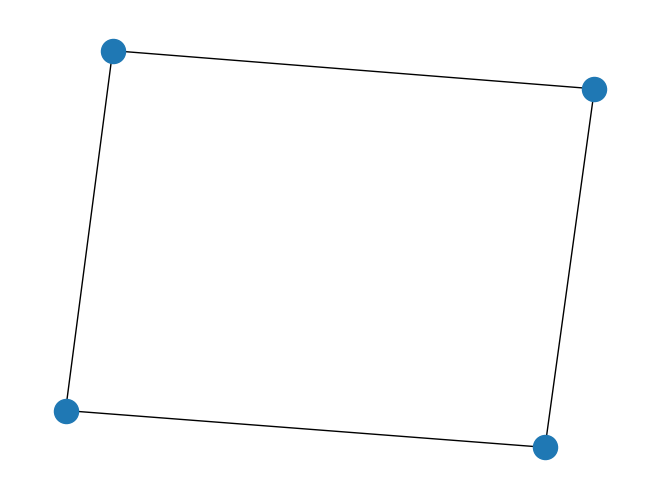

In [6]:
import networkx as nx
interaction_graph = nx.cycle_graph(4)
nx.draw(interaction_graph)

In [ ]:
Fig 1. The one dimensional periodic graph for 4 dipoles(qubits).

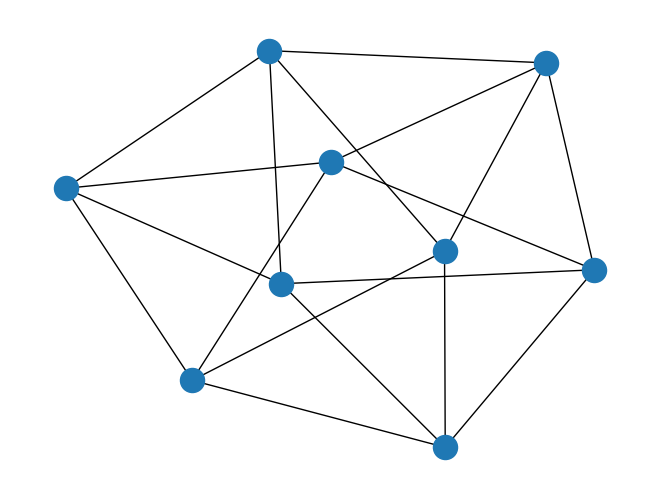

In [5]:
import networkx as nx
interaction_graph = nx.grid_graph((3,3), periodic=True)

nx.draw(interaction_graph)

Fig 2. The two dimensional periodic graph for 9 dipoles(qubits).


Code Implementation
==================
References: https://pennylane.ai/qml/demos/tutorial_vqt.html

The following code follows the procedure for obtaining the thermal density matrix via VQT from the demo "Variational Quantum Thermalizer" by Jack Ceroni(https://pennylane.ai/qml/demos/tutorial_vqt.html)

In [13]:
# Import Modules

import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.optimize import minimize
import networkx as nx
import itertools
from numpy import savetxt
from numba import jit
import time
import seaborn

In [14]:
# Initial Parameters and Constants
iterations = 0 # Initial Number of iterations 
depth = 4 # Depth of ansatz
nr_qubits = 9 # Number of dipoles(qubits)
h = 1 # External field term
beta_list = [round(1/k,2) for k in range(10,1,-1)]+[k for k in range(1,11)]
T = [1/beta for beta in beta_list]
E = []
C = []
M = []
cost_list = []
rho_list = []

interaction_graph = nx.grid_graph((3,3), periodic=True)
dev = qml.device("default.qubit", wires=nr_qubits)
z_matrix = 1

for i in range (nr_qubits):
    z_matrix = np.kron(z_matrix, qml.matrix(qml.PauliZ(0)))


In [9]:
#Creates the XY Hamiltonian for the case of an external magnetic field
def create_hamiltonian_matrix(n, graph):
    """
    Arguments: 
    n(int): Number of Qubits
    graph(nx.graph): Interaction graph
    
    Returns:
    matrix(np.array): XY Hamiltonian Matrix
    
    """
    
    
    
    
    matrix = np.zeros((2 ** n, 2 ** n))

    for i in graph.edges:
        x = y = 1
        for j in range(0, n):
                       
            if j == i[0] or j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
        
        matrix = np.add(matrix, np.add(x, y))
                
  
    for k in range(n):
        z = 1
        for l in range(k+1):
            if l == k:
                z = np.kron(z, qml.matrix(qml.PauliZ)(0))
            else:
                z = np.kron(z, np.identity(2))
                                
    matrix = np.add(matrix, h*z)
    

    return matrix

In [10]:
# Hamiltonian in the absence of an external magnetic field
def create_hamiltonian_matrix(n, graph):
    matrix = np.zeros((2 ** n, 2 ** n))

    for i in graph.edges:
        x = y = 1
        for j in range(0, n):
                       
            if j == i[0] or j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
        
        matrix = np.add(matrix, np.add(x, y))
                
  
    return matrix

In [15]:
ham_matrix = create_hamiltonian_matrix(nr_qubits, interaction_graph)

In [100]:
# Utility Functions


def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)


def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T



def convert_list(params):


    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)


    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]


def calculate_entropy(distribution):
    
    

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

  

    return total_entropy
def trace_distance(one, two):

    return 0.5 * np.trace(np.absolute(np.add(one, -1 * two)))

def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

In [103]:
# Ansatz Circuit


def single_rotation(phi_params, qubits):

    rotations = ["Z", "Y", "X"]
    for i in range(0, len(rotations)):
        qml.AngleEmbedding(phi_params[i], wires=qubits, rotation=rotations[i])




@qml.qnode(dev)
def quantum_circuit(rotation_params, coupling_params, sample=None):

    
    qml.BasisStatePreparation(sample, wires=range(nr_qubits))


    for i in range(0, depth):
        single_rotation(rotation_params[i], range(nr_qubits))
        qml.broadcast(
            unitary=qml.CRX,
            pattern="ring",
            wires=range(nr_qubits),
            parameters=coupling_params[i]
        )

    
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(nr_qubits)))





In [105]:
# Cost Functions

def exact_cost(params,beta):

    global iterations

   
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]
    distribution = prob_dist(dist_params)

    
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    
    cost = 0
    for i in s:
        result = quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result *= distribution[j][i[j]]
        cost += result
     

   
    entropy = calculate_entropy(distribution)
    final_cost = beta * cost - entropy

    return final_cost


def cost_execution(params,beta):
    

    global iterations
    

    cost = exact_cost(params,beta)
   
    cost_list.append(cost)
    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

In [107]:
# Execution Function
@jit(target_backend='cuda', forceobj=True) 	
def execute():
    start = time.time()
    
    for beta in beta_list:
        iterations = 0
        print(f'Starting beta={beta} training')
        number = nr_qubits * (1 + depth * 4)
        params = [np.random.randint(-300, 300) / 100 for i in range(0, number)]
        out = minimize(cost_execution, x0=params, args=(beta),method="COBYLA", options={"maxiter": 100})
        out_params = out["x"]
        prep_density_matrix = prepare_state(out_params, dev)
        savetxt(f'beta_is_{beta}.csv', cost_list, delimiter=',')
        savetxt(f'beta_is_{beta}_params.csv', out_params, delimiter=',')
        params = np.array(np.loadtxt(f'beta_is_{beta}_params.csv', dtype=float))
        cost = exact_cost(params, beta)
       
                
        
        energy = np.trace(np.matmul(prep_density_matrix, ham_matrix))
        capacitance = np.abs(np.trace(np.matmul(np.linalg.matrix_power(ham_matrix,2),prep_density_matrix)-np.matmul(prep_density_matrix, ham_matrix))) * (1/(nr_qubits-1))**2
        magnetization = np.abs(np.trace(np.matmul(prep_density_matrix, z_matrix))) * (1/(nr_qubits-1))**2
        
         
        rho_list.append(prep_density_matrix)
        E.append(energy)
        C.append(capacitance)
        M.append(magnetization)
        seaborn.heatmap(abs(prep_density_matrix))
        plt.show()
        
    end = time.time()

    print("Total execution time:", (end-start)/60, "m")





In [ ]:
# Plot Values
    
def plot():
    plt.plot(T,E,"bo")
    plt.xlabel('T')
    plt.ylabel('E')

    plt.plot(T,C,"go")
    plt.xlabel('T')
    plt.ylabel('C')

    plt.plot(T,M,"ro")
    plt.xlabel('T')
    plt.ylabel('M')

    plt.show()
    
    

Energy, Heat Capacity, Magnetism Calculations
======================================


0.1 start
0.10101937735329232 start
0.1020597513453331 start
0.10312177744445486 start
0.10420613868889732 start
0.10531354715174726 start
0.1064447455002903 start
0.10760050865695002 start
0.10878164556962026 start
0.10998900109989002 start
0.11122345803842265 start
0.11248593925759282 start
0.11377741001241208 start
0.11509888040179973 start
0.1164514080033877 start
0.11783610069630424 start
0.11925411968777104 start
0.12070668276089105 start
0.12219506776271939 start
0.12372061635361603 start
0.1252847380410023 start
0.12688891452301304 start
0.12853470437017997 start
0.1302237480762401 start
0.131957773512476 start
0.13373860182370823 start
0.1355681538082327 start
0.13744845682868925 start
0.1393816523061328 start
0.14137000385554557 start
0.14341590612777053 start
0.14552189443048025 start
0.1476906552094522 start
0.14992503748125938 start
0.15222806531967895 start
0.15460295151089248 start
0.15705311250713877 start
0.159582184825185 start
0.16219404305514598 start
0.164892819667

Text(0, 0.5, 'E')

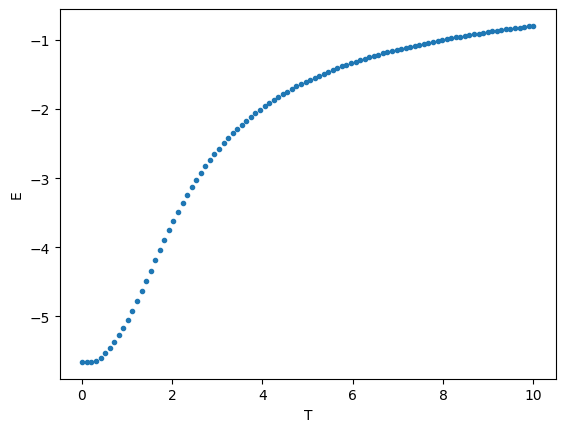

In [187]:
# Comparison to Exact Results

Energy

nr_qubits = 4
beta_list = [1/t for t in np.linspace(0.01,10,100)]
beta_list.sort()
exactenergy_list = []
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, interaction_graph)
    exactenergy = np.trace(hamiltonian@target_density_matrix)
    exactenergy_list.append(exactenergy)
    print(f"{beta} start", end=' ')
T = [1/beta for beta in beta_list]
plt.plot(T,exactenergy_list,'.')
plt.xlabel('T')
plt.ylabel('E')

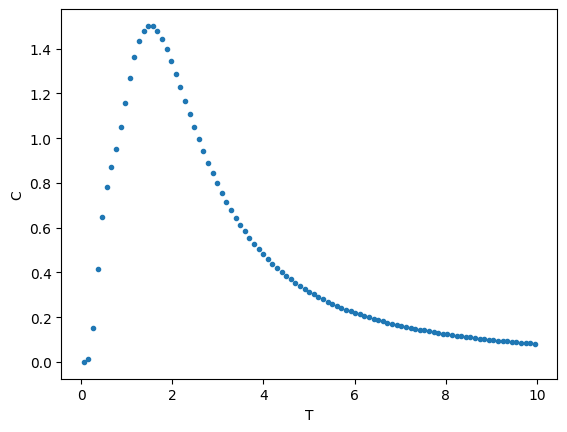

In [188]:
# Heat Capacity

plt.plot((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(exactenergy_list)),np.diff(np.array(T))),'.')
# plt.xlim([0,2])
plt.xlabel('T')
plt.ylabel('C')
plt.show()

In [ ]:
# Magnetism
